In [1]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns

from psm_utils import PSM, PSMList
from tqdm import tqdm
from denovo_utils.analysis.mixture_models import assign_ggm_clusters, plot_cluster_psmtype, get_ggm_n_clusters

from denovo_utils.analysis.evaluation import get_precision_metrics

import warnings
warnings.filterwarnings("ignore")

# 0. Load data

In [2]:
df = pd.read_pickle("F06_merged.pkl")

In [3]:
df_db = df[df["source"]=="sage"]
spectra_selection = df_db.loc[df_db["psm_type"]=="target_accepted", "spectrum_id"].tolist()

Filter out spectra with no ground-truth

In [4]:
df = df[df["spectrum_id"].isin(spectra_selection)]

In [5]:
ground_truth = df_db.loc[df_db["psm_type"]=="target_accepted", ["peptide", "spectrum_id"]].set_index("spectrum_id").to_dict("index")

def evaluate_prediction(row, ground_truth):
    ground_truth_peptidoform = ground_truth[row["spectrum_id"]]["peptide"]
    if isinstance(ground_truth_peptidoform, type(None)):
        return None
    return ground_truth_peptidoform == row["peptide"]

df["correct_prediction"] = df.apply(lambda x: evaluate_prediction(x, ground_truth), axis=1)

# 1. PSM-level

In [30]:
def setify(df):
    spec_pept = df.apply(
        lambda x: (x["spectrum_id"], x["peptide"]),
        axis=1
    )
    return spec_pept.tolist()

identifications = df[["spectrum_id", "peptide", "source"]].groupby("source").apply(
    setify
)

In [68]:
id_dict = identifications.to_dict()
id_dict = {k: set([" ".join(list(x)) for x in v]) for k, v in id_dict.items()}

In [69]:
for k, v in id_dict.items():
    print(k, len(v))

Casanovo4.2.0 40214
ContraNovo 20295
InstaNovo 40239
NovoB 39800
Novor 40224
PepNet 40270
PepNovo+ 33828
sage 40270


In [70]:
from upsetplot import from_contents, plot

data = from_contents(id_dict)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

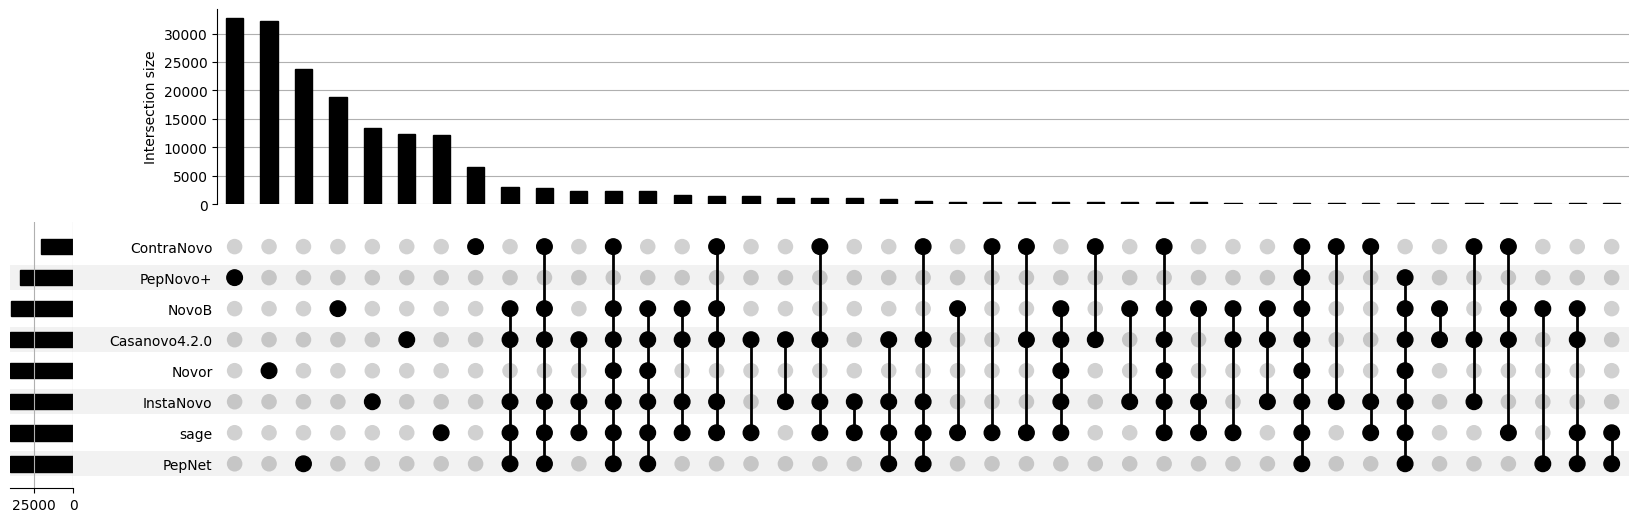

In [71]:
plot(data, min_subset_size=200, sort_by="cardinality")

In [40]:
from matplotlib_venn import venn3

In [41]:
id_dict = identifications.to_dict()

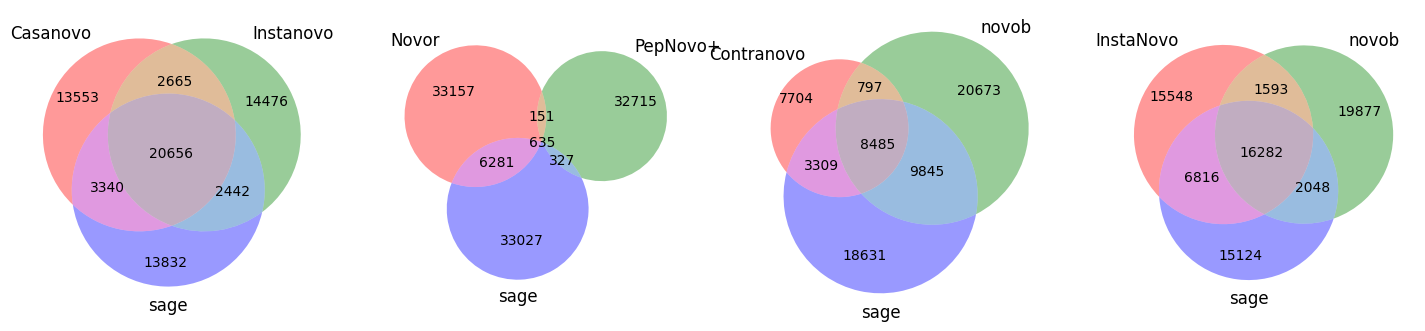

In [127]:
fig, ax = plt.subplots(1,4,figsize=(18,5))

venn3(
    subsets=(
        set(id_dict["Casanovo4.2.0"]),
        set(id_dict["InstaNovo"]),
        set(id_dict["sage"])
    ),
    set_labels=(
        "Casanovo",
        "Instanovo",
        "sage"
    ),
    ax=ax[0]
)

venn3(
    subsets=(
        set(id_dict["Novor"]),
        set(id_dict["PepNovo+"]),
        set(id_dict["sage"])
    ),
    set_labels=(
        "Novor",
        "PepNovo+",
        "sage"
    ),
    ax=ax[1]
)

venn3(
    subsets=(
        set(id_dict["ContraNovo"]),
        set(id_dict["NovoB"]),
        set(id_dict["sage"])
    ),
    set_labels=(
        "Contranovo",
        "novob",
        "sage"
    ),
    ax=ax[2]
)

venn3(
    subsets=(
        set(id_dict["InstaNovo"]),
        set(id_dict["NovoB"]),
        set(id_dict["sage"])
    ),
    set_labels=(
        "InstaNovo",
        "novob",
        "sage"
    ),
    ax=ax[3]
)

What is the overlap in predictions for those that are wrong?

In [86]:
df_false = df[~df["correct_prediction"]]

In [128]:
df_false_selection = df_false[df_false["source"].isin([
    "PepNet",
    "NovoB",
    "InstaNovo",
    "Casanovo4.2.0",
    "ContraNovo"
])]

In [129]:
df_false_selection.source.value_counts()

PepNet           25398
NovoB            21470
InstaNovo        17141
Casanovo4.2.0    16218
ContraNovo        8501
Name: source, dtype: int64

In [114]:
# spec_source_count = df_false_selection[["source", "spectrum_id"]].groupby("spectrum_id").count()
# all_wrong_spectra = spec_source_count[spec_source_count["source"]==5].index.tolist()
# df_false_selection = df_false_selection[df_false_selection["spectrum_id"].isin(all_wrong_spectra)]
# len(all_wrong_spectra)

In [130]:
def setify(df):
    spec_pept = df.apply(
        lambda x: (x["spectrum_id"], x["peptide"]),
        axis=1
    )
    return spec_pept.tolist()

identifications_false = df_false_selection[["spectrum_id", "peptide", "source"]].groupby("source").apply(
    setify
)

In [131]:
id_dict_false = identifications_false.to_dict()
id_dict_false = {k: set([" ".join(list(x)) for x in v]) for k, v in id_dict_false.items()}

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

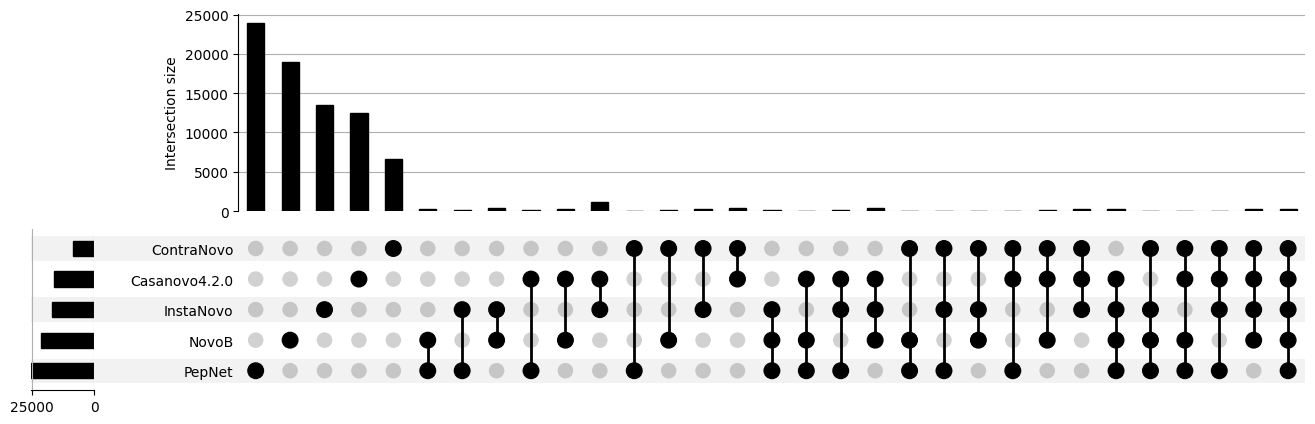

In [132]:
data = from_contents(id_dict_false)
plot(data)

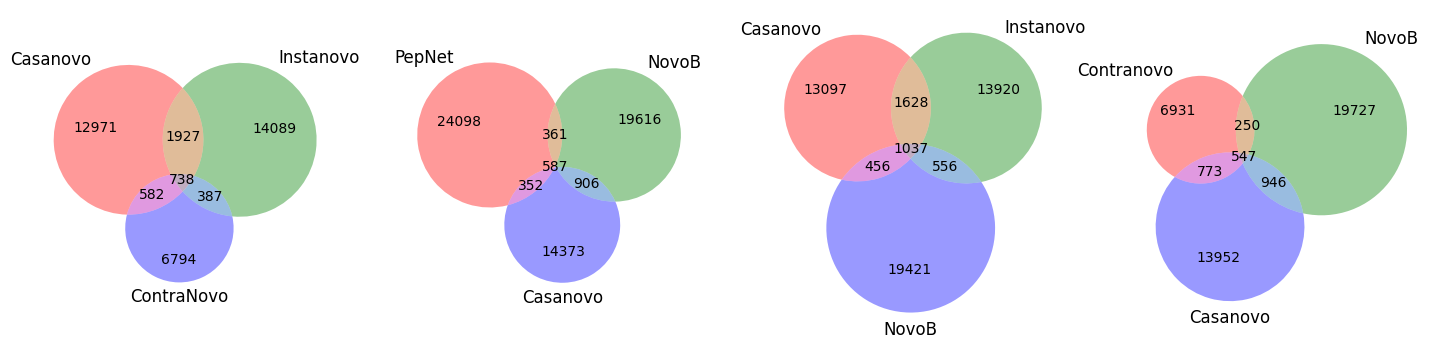

In [136]:
fig, ax = plt.subplots(1,4,figsize=(18,5))

venn3(
    subsets=(
        set(id_dict_false["Casanovo4.2.0"]),
        set(id_dict_false["InstaNovo"]),
        set(id_dict_false["ContraNovo"])
    ),
    set_labels=(
        "Casanovo",
        "Instanovo",
        "ContraNovo"
    ),
    ax=ax[0]
)

venn3(
    subsets=(
        set(id_dict_false["PepNet"]),
        set(id_dict_false["NovoB"]),
        set(id_dict_false["Casanovo4.2.0"])
    ),
    set_labels=(
        "PepNet",
        "NovoB",
        "Casanovo"
    ),
    ax=ax[1]
)

venn3(
    subsets=(
        set(id_dict_false["Casanovo4.2.0"]),
        set(id_dict_false["InstaNovo"]),
        set(id_dict_false["NovoB"])
    ),
    set_labels=(
        "Casanovo",
        "Instanovo",
        "NovoB"
    ),
    ax=ax[2]
)

venn3(
    subsets=(
        set(id_dict_false["ContraNovo"]),
        set(id_dict_false["NovoB"]),
        set(id_dict_false["Casanovo4.2.0"])
    ),
    set_labels=(
        "Contranovo",
        "NovoB",
        "Casanovo"
    ),
    ax=ax[3]
)

# 2. Peptide level

In [75]:
def setify_peptide(df):
    spec_pept = df.apply(
        lambda x: x["peptide"],
        axis=1
    )
    return spec_pept.tolist()

identifications = df[["spectrum_id", "peptide", "source"]].groupby("source").apply(
    setify_peptide
)

In [78]:
id_dict_peptide = identifications.to_dict()
id_dict_peptide = {k: set(v) for k,v in id_dict_peptide.items()}

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

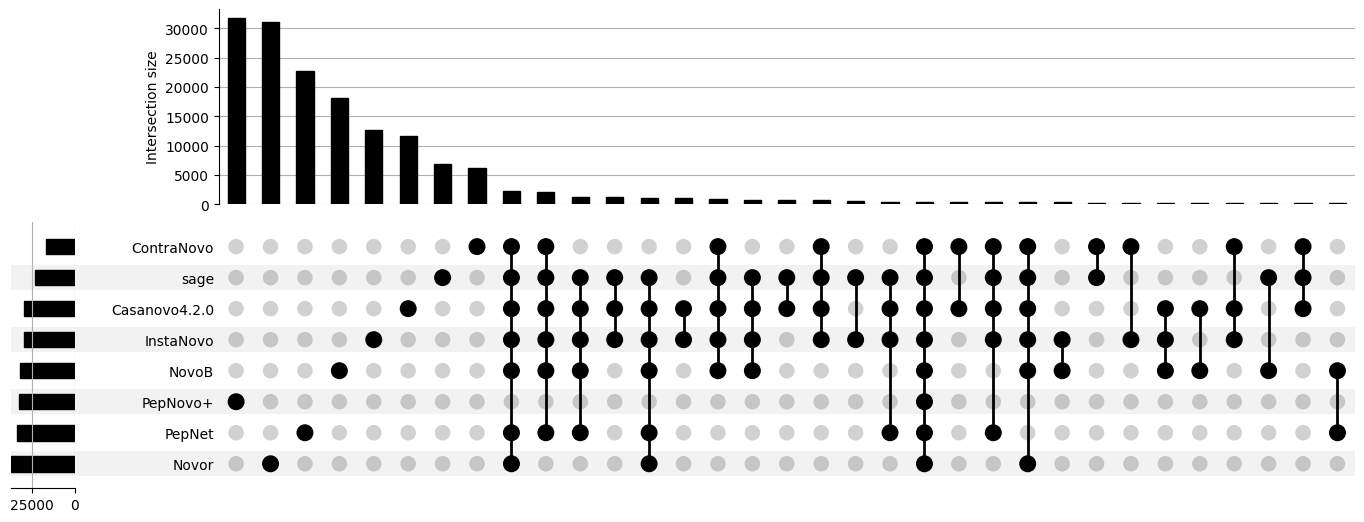

In [81]:
data=from_contents(id_dict_peptide)
plot(data, min_subset_size=200, sort_by="cardinality")